In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import random

from scipy import eye, asarray, dot, sum, diag
from scipy.linalg import svd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from netCDF4 import Dataset
from numpy import linspace
from numpy import meshgrid


import PCA_functions as pf
import Extreme_functions as ef

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, CMIknn
import tigramite.data_processing as pp

from Data import Data
from datetime import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import itertools
from collections import Counter
import pickle

from numpy import linalg as LA

import matplotlib.cm as cm

from scipy.special import inv_boxcox
from scipy import stats

from matplotlib import animation

import scipy.stats as st

import reverse_geocoder as rg

from pandas_datareader import wb
import scipy.stats as st

import Rung as rung

from pandas_datareader import wb

import seaborn as sns


import seaborn as sns
import feature_finder_keiko as ff
import feature_finder_f as ff1

from scipy import signal

plt.rcParams["figure.figsize"] = (20,10)

In [4]:
def EOF_plot(pc, df_sst, Vr, lat_sst, lon_sst):

    df_sst["pc"] = Vr[:,pc-1]

    #lon1 = np.arange(-178.75,179.0,2.5)
    lon1_sst = np.arange(-180,180,2)
    #lat1 = np.arange(-40,40,2.5)

    deg = np.zeros((len(lat_sst),len(lon1_sst)))

    lat_number = deg.shape[0]
    lon_number = deg.shape[1]

    for i in range(lat_number):
        for j in range(lon_number):
            if not df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].pc.values.size == 0:
                deg[i,j] = df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].pc.values
            else:
                deg[i,j]=np.nan


    plt.figure(figsize=(30,15))
    #map = Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
    map = Basemap(projection='ortho',lat_0=45,lon_0=-100,resolution='l')
    #map.fillcontinents(color='grey', alpha=0.5)
    #map.drawcoastlines(linewidth=0.)


    xx, yy = meshgrid(lon1_sst, lat_sst)
    cs = map.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
    cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
    cbar.ax.tick_params(labelsize=35)
    #plt.savefig("EOF1.png")
    plt.show()

In [121]:
# Using readlines()
file1 = open('ONI_1976_2015.txt', 'r')
Lines = file1.readlines()

NINO = []
for line in Lines:
    l = line.split()
    for i in range(1, len(l)):
        NINO.append(float(l[i]))

In [122]:
nino = np.array(NINO)

In [123]:
np.save("oni.npy", nino)

In [124]:
soi = np.load("oni.npy")

In [125]:
cc = "ET"

In [126]:
train_start = 1976
validation_end = 2010

test_start = 2011
test_end = 2015

result = []
for tau in np.arange(1,13):
    
    temporal_limits = {"time_min":datetime(train_start, 1, 1, 0, 0),"time_max":datetime(validation_end, 12, 1, 0, 0)}
    count, _ = ff.drought_timeseries("../npy_files/ET_gamma_18912015.npy",train_start,validation_end)

    start_lag = tau
    end_lag = tau + 11

    df_count = pd.DataFrame({"drought": count})
    lags = np.arange(start_lag,end_lag + 1)
    df_count = df_count.assign(**{
    '{} (t-{})'.format(col, t): df_count[col].shift(t)
    for t in lags
    for col in df_count
    })

    df_soi = pd.DataFrame({"soi": soi[:420]})
    lags = np.arange(start_lag,end_lag + 1)
    df_soi = df_soi.assign(**{
    '{} (t-{})'.format(col, t): df_soi[col].shift(t)
    for t in lags
    for col in df_soi
    })

    df_soi = df_soi.drop(['soi'],1)

    df = pd.concat([df_count, df_soi],axis=1)
    df = df.dropna()

    x_train = df.iloc[:,1:]
    y_train = df.iloc[:,0]
    model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
    model.fit(x_train, y_train)

    temporal_limits = {"time_min":datetime(test_start, 1, 1, 0, 0),"time_max":datetime(test_end, 12, 1, 0, 0)}
    count, _ = ff.drought_timeseries("../npy_files/ET_gamma_18912015.npy",test_start,test_end)

    df_count = pd.DataFrame({"drought": count})
    lags = np.arange(start_lag,end_lag + 1)
    df_count = df_count.assign(**{
    '{} (t-{})'.format(col, t): df_count[col].shift(t)
    for t in lags
    for col in df_count
    })

    df_soi = pd.DataFrame({"soi": soi[420:]})
    lags = np.arange(start_lag,end_lag + 1)
    df_soi = df_soi.assign(**{
    '{} (t-{})'.format(col, t): df_soi[col].shift(t)
    for t in lags
    for col in df_soi
    })

    df_soi = df_soi.drop(['soi'],1)

    df = pd.concat([df_count, df_soi],axis=1)
    df = df.dropna()

    x_test = df.iloc[:,1:]
    y_test = df.iloc[:,0]

    y_pred = model.predict(x_test)

    result.append(math.sqrt(mean_squared_error(y_pred, y_test))/303)
    

In [127]:
result

[0.03033597232940087,
 0.05591597284534927,
 0.08590425553771264,
 0.11364887303366765,
 0.1401371430091104,
 0.15995170437835393,
 0.17500366638311618,
 0.17936686618314338,
 0.18522468711415732,
 0.18625598777438906,
 0.18629406954822164,
 0.18502910758713526]

In [120]:
result

[0.030078338834940106,
 0.05405810497954464,
 0.08527803771838126,
 0.1122263102051953,
 0.13354592586674682,
 0.15406234103315353,
 0.16294347303107817,
 0.17176778015670402,
 0.17137072003608397,
 0.17598612517033413,
 0.181671625856221,
 0.18566476438927246]

In [101]:


temporal_limits = {"time_min":datetime(train_start, 1, 1, 0, 0),"time_max":datetime(validation_end, 12, 1, 0, 0)}
count, _ = ff.drought_timeseries("../npy_files/ET_gamma_18912015.npy",train_start,validation_end)

In [102]:
start_lag = tau
end_lag = tau + 11

In [103]:
df_count = pd.DataFrame({"drought": count})
lags = np.arange(start_lag,end_lag + 1)
df_count = df_count.assign(**{
'{} (t-{})'.format(col, t): df_count[col].shift(t)
for t in lags
for col in df_count
})

In [104]:
df_soi = pd.DataFrame({"soi": soi[:420]})
lags = np.arange(start_lag,end_lag + 1)
df_soi = df_soi.assign(**{
'{} (t-{})'.format(col, t): df_soi[col].shift(t)
for t in lags
for col in df_soi
})

In [105]:
df_soi = df_soi.drop(['soi'],1)

In [106]:
df_nino = pd.DataFrame({"nino": nino[:420]})
lags = np.arange(start_lag,end_lag + 1)
df_nino = df_nino.assign(**{
'{} (t-{})'.format(col, t): df_nino[col].shift(t)
for t in lags
for col in df_nino
})

In [107]:
df_nino = df_nino.drop(['nino'],1)

In [108]:
df = pd.concat([df_count, df_soi, df_nino],axis=1)

In [109]:
df = df.dropna()

In [110]:
x_train = df.iloc[:,1:]
y_train = df.iloc[:,0]
model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
model.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [111]:
test_start = 2011
test_end = 2015

temporal_limits = {"time_min":datetime(test_start, 1, 1, 0, 0),"time_max":datetime(test_end, 12, 1, 0, 0)}
count, _ = ff.drought_timeseries("../npy_files/ET_gamma_18912015.npy",test_start,test_end)

In [112]:
start_lag = tau
end_lag = tau + 11

df_count = pd.DataFrame({"drought": count})
lags = np.arange(start_lag,end_lag + 1)
df_count = df_count.assign(**{
'{} (t-{})'.format(col, t): df_count[col].shift(t)
for t in lags
for col in df_count
})


df_soi = pd.DataFrame({"soi": soi[420:]})
lags = np.arange(start_lag,end_lag + 1)
df_soi = df_soi.assign(**{
'{} (t-{})'.format(col, t): df_soi[col].shift(t)
for t in lags
for col in df_soi
})

df_soi = df_soi.drop(['soi'],1)


df_nino = pd.DataFrame({"nino": nino[420:]})
lags = np.arange(start_lag,end_lag + 1)
df_nino = df_nino.assign(**{
'{} (t-{})'.format(col, t): df_nino[col].shift(t)
for t in lags
for col in df_nino
})

df_nino = df_nino.drop(['nino'],1)

df = pd.concat([df_count, df_soi, df_nino],axis=1)

df = df.dropna()

In [113]:
x_test = df.iloc[:,1:]
y_test = df.iloc[:,0]

y_pred = model.predict(x_test)

In [114]:
math.sqrt(mean_squared_error(y_pred, y_test))/303

0.15916179771200456

In [115]:
df

,drought,drought (t-6),drought (t-7),drought (t-8),drought (t-9),drought (t-10),drought (t-11),drought (t-12),drought (t-13),drought (t-14),...,nino (t-8),nino (t-9),nino (t-10),nino (t-11),nino (t-12),nino (t-13),nino (t-14),nino (t-15),nino (t-16),nino (t-17)
17,0,24.0,37.0,48.0,59.0,93.0,96.0,96.0,80.0,59.0,...,-0.93,-0.76,-0.66,-0.23,-0.25,-0.53,-0.74,-0.98,-1.26,-1.70
18,1,23.0,24.0,37.0,48.0,59.0,93.0,96.0,96.0,80.0,...,-1.09,-0.93,-0.76,-0.66,-0.23,-0.25,-0.53,-0.74,-0.98,-1.26
19,0,20.0,23.0,24.0,37.0,48.0,59.0,93.0,96.0,96.0,...,-1.05,-1.09,-0.93,-0.76,-0.66,-0.23,-0.25,-0.53,-0.74,-0.98
20,0,22.0,20.0,23.0,24.0,37.0,48.0,59.0,93.0,96.0,...,-0.93,-1.05,-1.09,-0.93,-0.76,-0.66,-0.23,-0.25,-0.53,-0.74
21,0,19.0,22.0,20.0,23.0,24.0,37.0,48.0,59.0,93.0,...,-0.61,-0.93,-1.05,-1.09,-0.93,-0.76,-0.66,-0.23,-0.25,-0.53
22,0,0.0,19.0,22.0,20.0,23.0,24.0,37.0,48.0,59.0,...,-0.48,-0.61,-0.93,-1.05,-1.09,-0.93,-0.76,-0.66,-0.23,-0.25
23,0,0.0,0.0,19.0,22.0,20.0,23.0,24.0,37.0,48.0,...,-0.29,-0.48,-0.61,-0.93,-1.05,-1.09,-0.93,-0.76,-0.66,-0.23
24,0,1.0,0.0,0.0,19.0,22.0,20.0,23.0,24.0,37.0,...,-0.18,-0.29,-0.48,-0.61,-0.93,-1.05,-1.09,-0.93,-0.76,-0.66
25,0,0.0,1.0,0.0,0.0,19.0,22.0,20.0,23.0,24.0,...,0.14,-0.18,-0.29,-0.48,-0.61,-0.93,-1.05,-1.09,-0.93,-0.76
26,1,0.0,0.0,1.0,0.0,0.0,19.0,22.0,20.0,23.0,...,0.44,0.14,-0.18,-0.29,-0.48,-0.61,-0.93,-1.05,-1.09,-0.93


In [ ]:
    df = shift_df(df, start_lag, end_lag)
    index = int(df.shape[0]*ratio)
    dim = df.shape[1]
    x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim]
    y_train, y_test = df.iloc[:index,0], df.iloc[index:,0]
    base_model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    base_model.fit(x_train, y_train)
    y_pred = base_model.predict(x_test)
    result.append(mean_squared_error(y_pred, y_test))
    
    df = pd.DataFrame({"drought": count})
    lags = np.arange(start_lag,end_lag + 1)
    df = df.assign(**{
    '{} (t-{})'.format(col, t): df[col].shift(t)
    for t in lags
    for col in df
    })
    for k in range(len(link)):
        df[str(k)] = time_series_maker_V(data_sst, V[:,link[k,0]-1])
        df[str(k)] = df[str(k)].shift(abs(link[k,1]))
    df = df.dropna()

In [5]:
tau = 12

In [6]:
lags = np.arange(-tau,-tau - 12,-1)

c = np.ones(12)
c = c.astype(int)
#c = c*2

link_ENSO = np.vstack((c,lags)).T

In [25]:
link_caus = np.load("../../whole_data_results/link_rotated_ET/best_link_all_1930_2000_{}.npy".format(tau))
link_corr = np.load("../../whole_data_results/link_rotated_ET/best_link_all_corr_1930_2000_{}.npy".format(tau))

In [3]:
tau =1

In [7]:
link_ENSO

array([[  1, -12],
       [  1, -13],
       [  1, -14],
       [  1, -15],
       [  1, -16],
       [  1, -17],
       [  1, -18],
       [  1, -19],
       [  1, -20],
       [  1, -21],
       [  1, -22],
       [  1, -23]])

In [26]:
link_caus

array([[ 13, -15],
       [ 91, -18],
       [ 66, -22],
       [ 51, -14],
       [ 66, -20],
       [ 90, -12],
       [ 85, -14],
       [ 65, -20],
       [ 72, -23],
       [ 82, -16],
       [  3, -20],
       [ 50, -15],
       [ 46, -14],
       [ 60, -20],
       [ 71, -15]])

In [27]:
link_corr

array([[ 13, -13],
       [ 60, -22],
       [ 21, -19],
       [ 66, -20],
       [ 90, -12],
       [ 97, -19],
       [  4, -17],
       [ 71, -23],
       [ 42, -23],
       [ 22, -21],
       [ 29, -19],
       [ 25, -23],
       [ 42, -22],
       [ 90, -13],
       [ 67, -15],
       [ 43, -14]])

In [15]:
np.intersect1d(link_corr[:,0], link_caus[:,0])

array([13, 60, 66, 71, 90])

In [28]:
link_ENSO

array([[  1, -12],
       [  1, -13],
       [  1, -14],
       [  1, -15],
       [  1, -16],
       [  1, -17],
       [  1, -18],
       [  1, -19],
       [  1, -20],
       [  1, -21],
       [  1, -22],
       [  1, -23]])

In [8]:
    start_lag = tau
    end_lag = tau + 11
    df = pd.DataFrame({"drought":count})

    df = ff.shift_df(df, start_lag, end_lag)

In [9]:
df

,drought,drought (t-1),drought (t-2),drought (t-3),drought (t-4),drought (t-5),drought (t-6),drought (t-7),drought (t-8),drought (t-9),drought (t-10),drought (t-11),drought (t-12)
12,-27.099679,-26.089460,-26.079241,-27.069023,-39.058804,-49.048585,-43.038366,-49.028148,-50.017929,-46.007710,-43.997492,-42.987273,-24.977054
13,-25.109897,-27.099679,-26.089460,-26.079241,-27.069023,-39.058804,-49.048585,-43.038366,-49.028148,-50.017929,-46.007710,-43.997492,-42.987273
14,-25.120116,-25.109897,-27.099679,-26.089460,-26.079241,-27.069023,-39.058804,-49.048585,-43.038366,-49.028148,-50.017929,-46.007710,-43.997492
15,-24.130335,-25.120116,-25.109897,-27.099679,-26.089460,-26.079241,-27.069023,-39.058804,-49.048585,-43.038366,-49.028148,-50.017929,-46.007710
16,28.859446,-24.130335,-25.120116,-25.109897,-27.099679,-26.089460,-26.079241,-27.069023,-39.058804,-49.048585,-43.038366,-49.028148,-50.017929
...,...,...,...,...,...,...,...,...,...,...,...,...,...
847,25.367694,3.377913,3.388132,27.398350,44.408569,5.418788,5.429007,4.439225,10.449444,8.459663,19.469881,17.480100,2.490319
848,25.357476,25.367694,3.377913,3.388132,27.398350,44.408569,5.418788,5.429007,4.439225,10.449444,8.459663,19.469881,17.480100
849,20.347257,25.357476,25.367694,3.377913,3.388132,27.398350,44.408569,5.418788,5.429007,4.439225,10.449444,8.459663,19.469881
850,15.337038,20.347257,25.357476,25.367694,3.377913,3.388132,27.398350,44.408569,5.418788,5.429007,4.439225,10.449444,8.459663


In [7]:
train_start = 1930
validation_end = 2000

n_components_sst = 98

temporal_limits = {"time_min":datetime(train_start, 1, 1, 0, 0),"time_max":datetime(validation_end, 12, 1, 0, 0)}
original_count, count = ff.drought_timeseries("../npy_files/ET_gamma_18912015.npy",train_start,validation_end)
data_sst, ts, V, df_sst, avg, std = ff.PCA_computer_rotated('../../../nc/sst.mnmean.nc', "sst",temporal_limits, n_components_sst, -9.96921e+36)

test_start = 2001
test_end = 2015

temporal_limits_test = {"time_min":datetime(test_start, 1, 1, 0, 0),"time_max":datetime(test_end, 12, 1, 0, 0)}
data_sst_test = ff.data_generator_avg_std('../../../nc/sst.mnmean.nc', "sst",temporal_limits_test, avg, std, 12, -9.96921e+36)
original_count_test, count_test = ff.drought_timeseries("../npy_files/ET_gamma_18912015.npy",test_start,test_end)

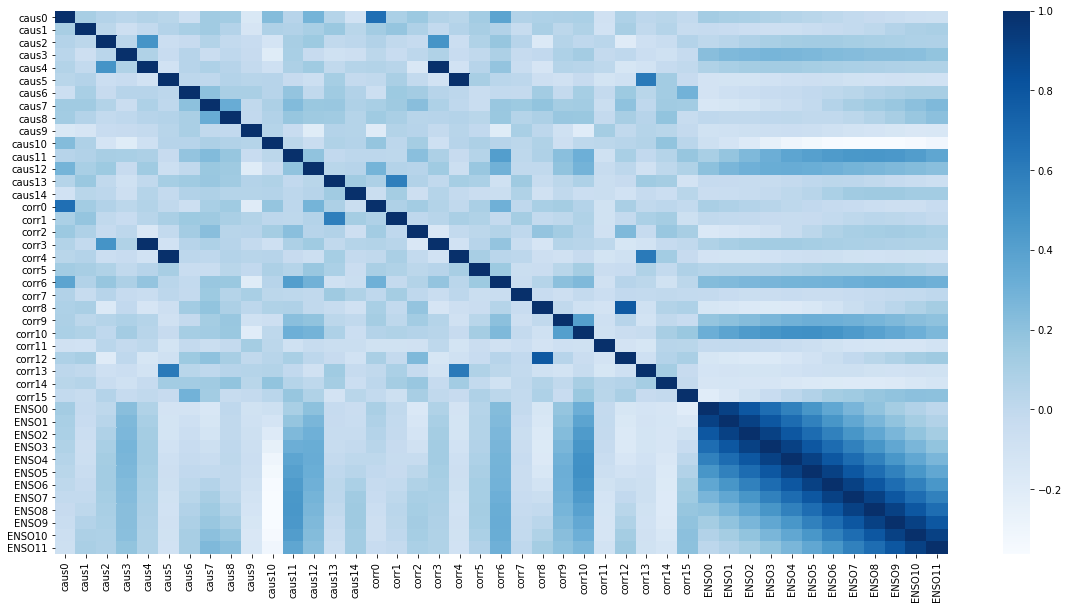

In [30]:
df = pd.DataFrame()

for k in range(len(link_caus)):
    df['caus'+str(k)] = ff.time_series_maker_V(data_sst, V[:,link_caus[k,0]-1])
    df['caus'+str(k)] = df['caus'+str(k)].shift(abs(link_caus[k,1]))
#df = df.dropna()

for k in range(len(link_corr)):
    df['corr'+str(k)] = ff.time_series_maker_V(data_sst, V[:,link_corr[k,0]-1])
    df['corr'+str(k)] = df['corr'+str(k)].shift(abs(link_corr[k,1]))
    
for k in range(len(link_ENSO)):
    df['ENSO'+str(k)] = ff.time_series_maker_V(data_sst, V[:,link_ENSO[k,0]-1])
    df['ENSO'+str(k)] = df['ENSO'+str(k)].shift(abs(link_ENSO[k,1]))
df = df.dropna()

sns.heatmap(df.corr(),cmap="Blues")

In [147]:
#plt.plot(df["caus2"].values)

In [148]:
#plt.plot(df["corr7"].values)

In [32]:
df_caus = df.iloc[:,:len(link_caus)].copy()
df_corr = df.iloc[:,len(link_caus):len(link_caus)+len(link_corr)].copy()
df_ENSO = df.iloc[:,len(link_caus)+len(link_corr):].copy()

In [38]:
V_caus, U_caus, S_caus, ts_caus, eig_caus, explained_caus, max_comps_caus = rung.pca_svd(df_caus)

In [39]:
V_corr, U_corr, S_corr, ts_corr, eig_corr, explained_corr, max_comps_corr = rung.pca_svd(df_corr)

In [40]:
stats.pearsonr(ts_corr[:,0], ts_caus[:,0])

(0.3370819056356317, 1.7836965144722324e-23)

In [41]:
stats.pearsonr(ts_corr[:,1], ts_caus[:,1])

(-0.16497980763257222, 1.7903630760667197e-06)

In [49]:
stats.pearsonr(ts_caus[:,0], df_ENSO.iloc[:,0].values)

(-0.03146670170210887, 0.36554081743524103)

In [154]:
x = np.arange(len(ts_corr[:,0]))

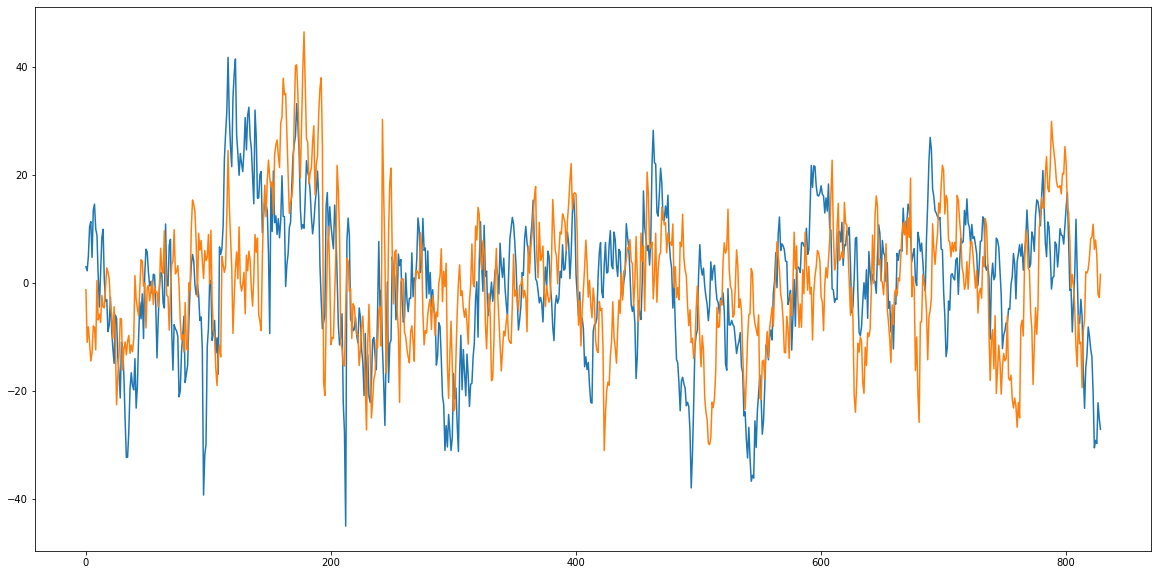

In [155]:
plt.plot(x,ts_corr[:,0],x,ts_caus[:,0])

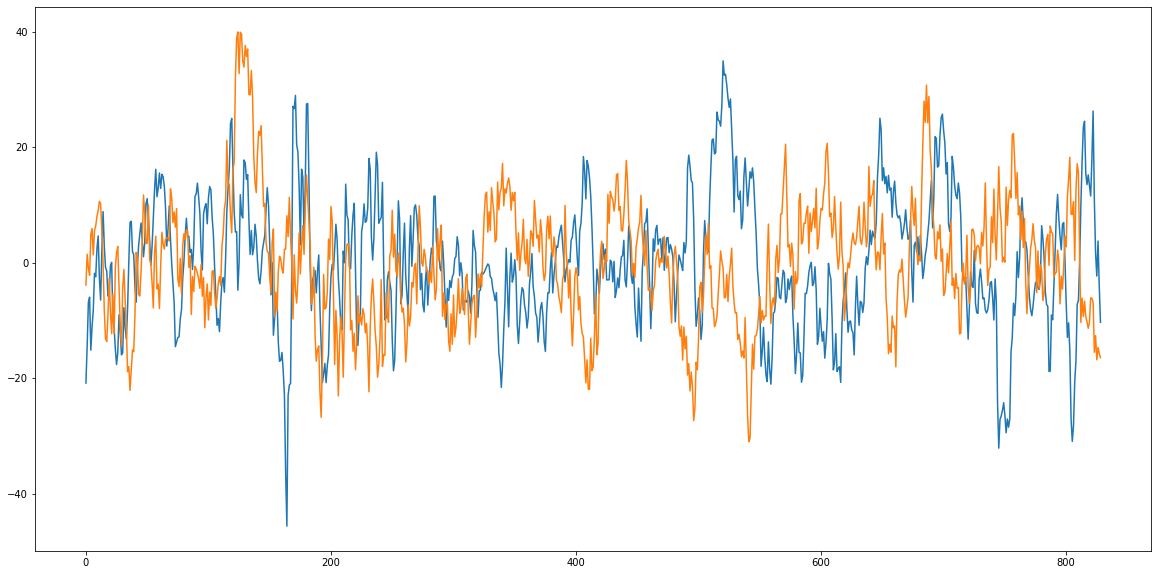

In [156]:
plt.plot(x,ts_corr[:,1],x,ts_caus[:,1])

In [66]:
class_name = "BSh"

tau = 12

link_caus = np.load("../../whole_data_results/link_rotated_ET/best_link_all_1930_2000_{}_{}.npy".format(tau, class_name))
link_corr = np.load("../../whole_data_results/link_rotated_ET/best_link_corr_all_1930_2000_{}_{}.npy".format(tau, class_name))

In [67]:
link_caus

array([[  2, -17],
       [ 42, -22],
       [ 27, -23],
       [ 53, -21],
       [ 11, -22],
       [ 11, -12],
       [  7, -13],
       [ 82, -13],
       [ 66, -14],
       [ 25, -19],
       [  3, -13],
       [ 56, -19],
       [  9, -17],
       [ 82, -18],
       [ 42, -24],
       [ 36, -19],
       [ 38, -12],
       [ 82, -15]])

In [68]:
link_corr

array([[ 51, -14],
       [ 85, -13],
       [ 11, -20],
       [ 42, -21],
       [ 69, -14],
       [ 42, -22],
       [ 75, -14],
       [ 27, -22],
       [ 25, -24],
       [ 61, -18],
       [ 84, -13],
       [ 55, -13],
       [ 85, -16],
       [ 69, -12],
       [ 55, -14],
       [ 79, -16],
       [ 23, -16],
       [  8, -20],
       [ 70, -15]])

In [69]:
np.intersect1d(link_corr[:,0], link_caus[:,0])

array([11, 25, 27, 42])

In [70]:
train_start = 1930
validation_end = 2000

n_components_sst = 87

temporal_limits = {"time_min":datetime(train_start, 1, 1, 0, 0),"time_max":datetime(validation_end, 12, 1, 0, 0)}
original_count, count = ff.drought_timeseries("../npy_files/ET_gamma_18912015.npy",train_start,validation_end)
data_sst, ts, V, df_sst, avg, std = ff.PCA_computer_rotated('../../../nc/sst.mnmean.nc', "sst",temporal_limits, n_components_sst, -9.96921e+36)

test_start = 2001
test_end = 2015

temporal_limits_test = {"time_min":datetime(test_start, 1, 1, 0, 0),"time_max":datetime(test_end, 12, 1, 0, 0)}
data_sst_test = ff.data_generator_avg_std('../../../nc/sst.mnmean.nc', "sst",temporal_limits_test, avg, std, 12, -9.96921e+36)
original_count_test, count_test = ff.drought_timeseries("../npy_files/ET_gamma_18912015.npy",test_start,test_end)


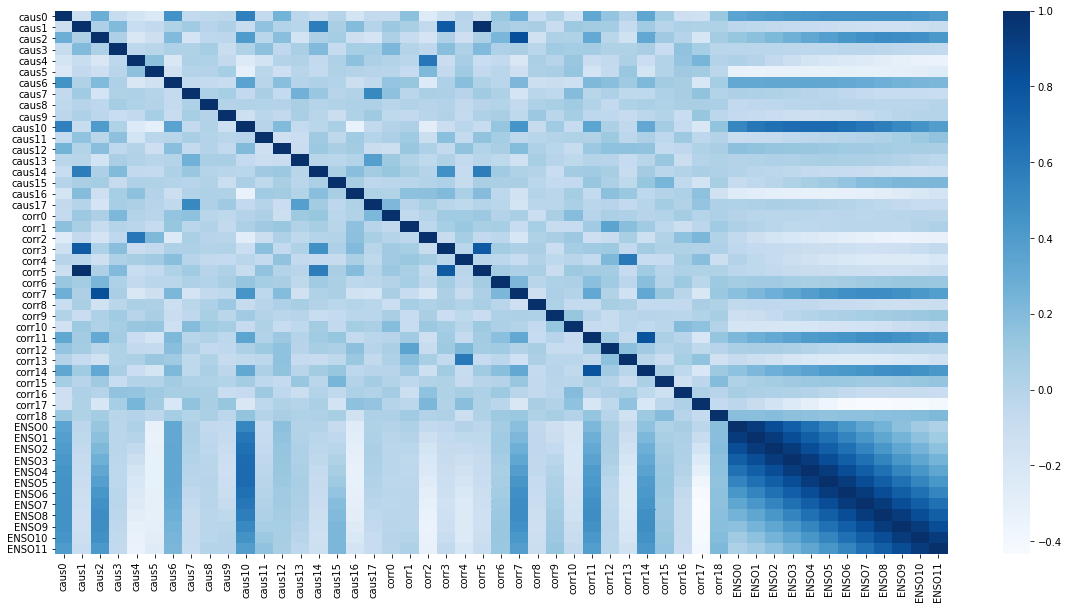

In [71]:
df = pd.DataFrame()

for k in range(len(link_caus)):
    df['caus'+str(k)] = ff.time_series_maker_V(data_sst, V[:,link_caus[k,0]-1])
    df['caus'+str(k)] = df['caus'+str(k)].shift(abs(link_caus[k,1]))
#df = df.dropna()

for k in range(len(link_corr)):
    df['corr'+str(k)] = ff.time_series_maker_V(data_sst, V[:,link_corr[k,0]-1])
    df['corr'+str(k)] = df['corr'+str(k)].shift(abs(link_corr[k,1]))
    
for k in range(len(link_ENSO)):
    df['ENSO'+str(k)] = ff.time_series_maker_V(data_sst, V[:,link_ENSO[k,0]-1])
    df['ENSO'+str(k)] = df['ENSO'+str(k)].shift(abs(link_ENSO[k,1]))
df = df.dropna()

sns.heatmap(df.corr(),cmap="Blues")

In [72]:
df_caus = df.iloc[:,:len(link_caus)].copy()
df_corr = df.iloc[:,len(link_caus):len(link_caus)+len(link_corr)].copy()
df_ENSO = df.iloc[:,len(link_caus)+len(link_corr):].copy()

V_caus, U_caus, S_caus, ts_caus, eig_caus, explained_caus, max_comps_caus = rung.pca_svd(df_caus)

V_corr, U_corr, S_corr, ts_corr, eig_corr, explained_corr, max_comps_corr = rung.pca_svd(df_corr)

In [73]:
stats.pearsonr(ts_corr[:,0], ts_caus[:,0])

(-0.5467647025546335, 9.958902725948382e-66)

In [74]:
stats.pearsonr(ts_corr[:,1], ts_caus[:,1])

(0.6805458581852072, 1.100467804250875e-113)

In [76]:
stats.pearsonr(ts_corr[:,0], df_ENSO.iloc[:,0].values)

(-0.1787262602980691, 2.257072958886048e-07)

In [77]:
x = np.arange(len(ts_corr[:,0]))

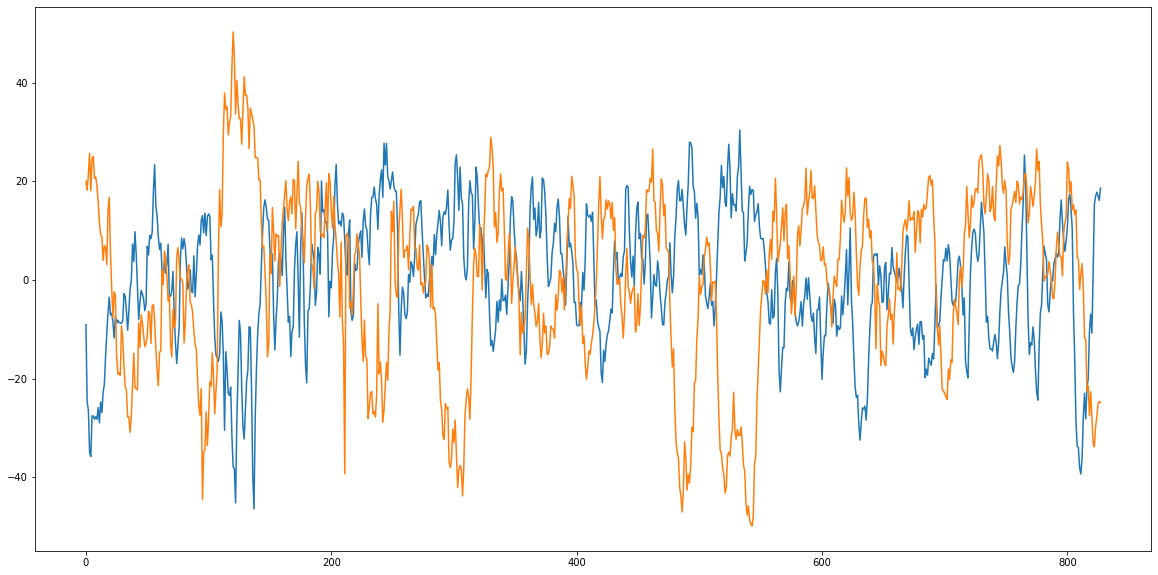

In [78]:
plt.plot(x,ts_corr[:,0],x,ts_caus[:,0])

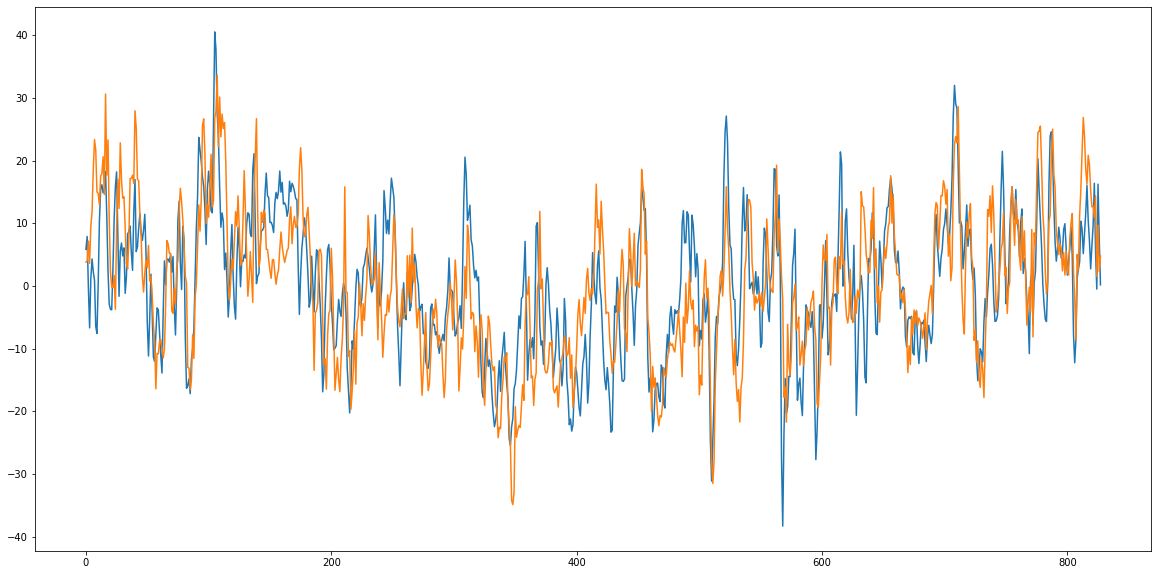

In [79]:
plt.plot(x,ts_corr[:,1],x,ts_caus[:,1])

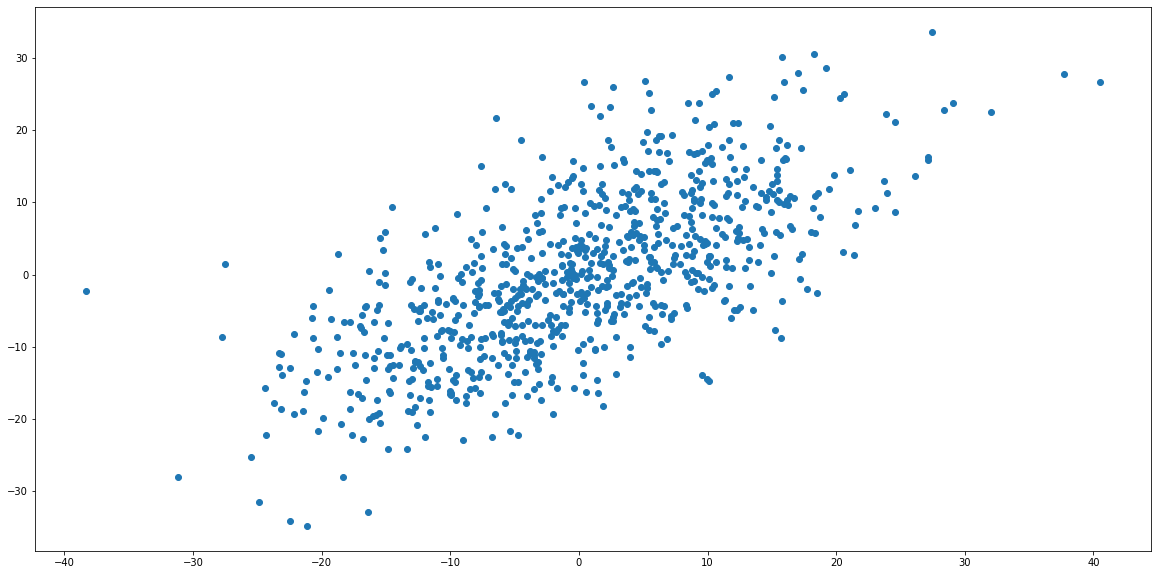

In [80]:
plt.scatter(ts_corr[:,1],ts_caus[:,1])

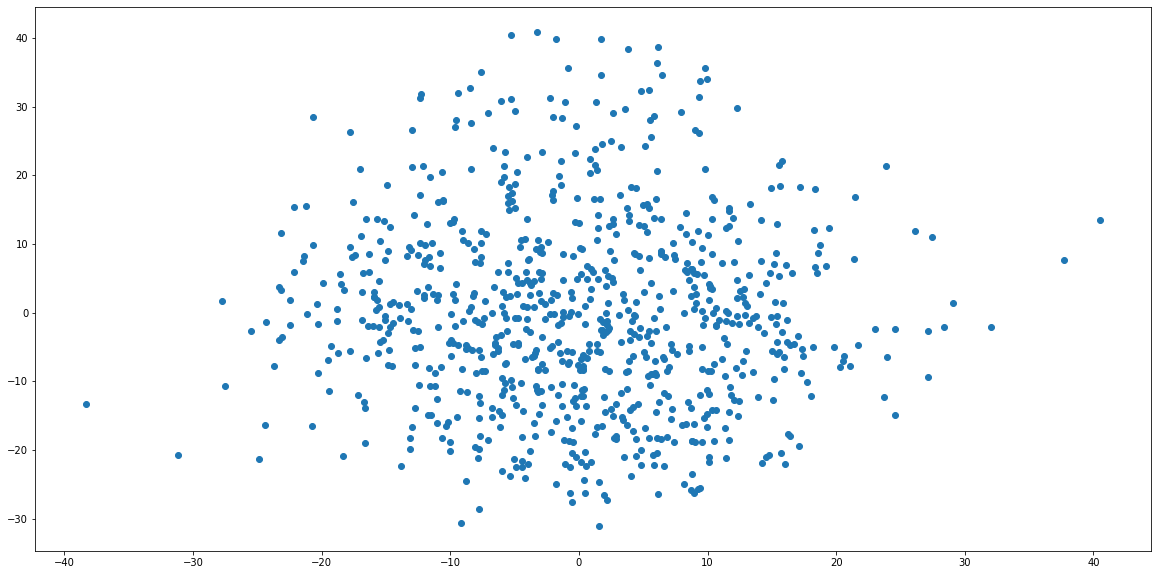

In [81]:
plt.scatter(ts_corr[:,1],df_ENSO.iloc[:,0].values)

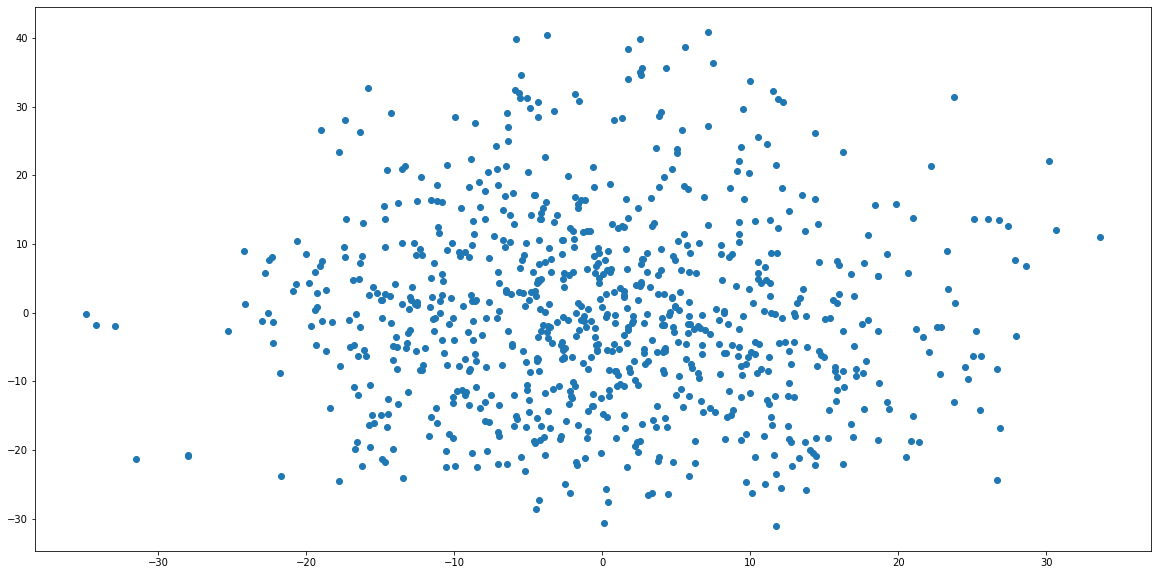

In [82]:
plt.scatter(ts_caus[:,1],df_ENSO.iloc[:,0].values)